In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import random
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [36]:
# Hyperparameters
image_size = 64
batch_size = 64
num_epochs = 3  # Increased for better training
learning_rate = 0.001
vocab_size = 20
message_length = 5
num_distractors = 3
temperature = 1.0

# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [37]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


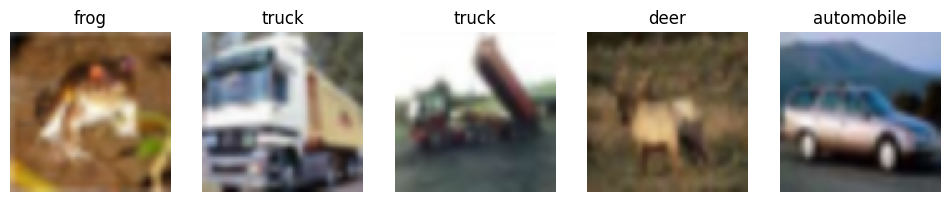

In [38]:
# Visualize sample images from the dataset
def visualize_samples(dataset, num_samples=5):
    classes = dataset.classes
    figure = plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        plt.subplot(1, num_samples, i+1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(classes[label])
        plt.axis('off')
    plt.show()

visualize_samples(train_dataset)

The collate_fn function prepares batches with target images and distractors.
Each batch contains the target image and a set of candidate images (including distractors).
The target is always at position 0 in the candidate images.

In [39]:
# Custom collate function
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    batch_size = images.size(0)

    # Get distractor indices
    target_indices = list(range(batch_size))
    distractor_indices = get_distractors(train_dataset, target_indices, num_distractors)
    candidate_images = []
    candidate_labels = []
    for i in range(batch_size):
        candidates = [images[i]]  # Target image
        candidate_labels_i = [labels[i]]  # Target label
        for idx in distractor_indices[i]:
            img, lbl = train_dataset[idx]
            candidates.append(img)
            candidate_labels_i.append(lbl)
        candidates = torch.stack(candidates)
        candidate_images.append(candidates)
        candidate_labels.append(candidate_labels_i)
    candidate_images = torch.stack(candidate_images)  # Shape: (batch_size, num_candidates, C, H, W)
    target_positions = torch.zeros(batch_size, dtype=torch.long)
    return images, labels, candidate_images, candidate_labels, target_positions

def get_distractors(dataset, target_indices, num_distractors):
    distractor_indices = []
    all_indices = set(range(len(dataset)))
    for idx in target_indices:
        possible_indices = list(all_indices - {idx})
        distractors = random.sample(possible_indices, num_distractors)
        distractor_indices.append(distractors)
    return distractor_indices

In [40]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

The Sender encodes images into messages using convolutional layers.
Uses Gumbel-Softmax to sample discrete messages that are differentiable.

In [41]:
class Sender(nn.Module):
    def __init__(self, vocab_size, message_length):
        super(Sender, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(128 * 8 * 8, message_length * vocab_size)
        self.vocab_size = vocab_size
        self.message_length = message_length

    def forward(self, images):
        batch_size = images.size(0)
        features = self.encoder(images)
        logits = self.fc(features)
        logits = logits.view(batch_size, self.message_length, self.vocab_size)
        messages = F.gumbel_softmax(logits, tau=temperature, hard=True)
        return messages

The Receiver processes the message using an embedding layer and a GRU.
Candidate images are encoded using convolutional layers.
The model computes similarity between the message and each candidate image.

In [42]:
class Receiver(nn.Module):
    def __init__(self, vocab_size, message_length):
        super(Receiver, self).__init__()
        self.message_length = message_length
        self.vocab_size = vocab_size
        self.embedding = nn.Linear(vocab_size, 128)
        self.message_processor = nn.GRU(128, 256, batch_first=True)
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256)
        )

    def forward(self, messages, candidate_images):
        batch_size = candidate_images.size(0)
        num_candidates = candidate_images.size(1)

        # Process messages
        messages = messages.view(batch_size, self.message_length, self.vocab_size)
        embedded = self.embedding(messages)
        _, hidden = self.message_processor(embedded)
        message_features = hidden.squeeze(0)

        # Encode candidate images
        candidate_images = candidate_images.view(batch_size * num_candidates, 3, image_size, image_size)
        image_features = self.image_encoder(candidate_images)
        image_features = image_features.view(batch_size, num_candidates, -1)

        # Compute similarities
        message_features = message_features.unsqueeze(1).repeat(1, num_candidates, 1)
        similarities = torch.sum(message_features * image_features, dim=2)
        probs = F.log_softmax(similarities, dim=1)
        return probs

In [43]:
# Instantiate models
sender = Sender(vocab_size=vocab_size, message_length=message_length).to(device)
receiver = Receiver(vocab_size=vocab_size, message_length=message_length).to(device)

In [44]:
# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=learning_rate)

Trains both the Sender and Receiver models.
Uses the negative log-likelihood loss function.
Records the training loss and accuracy for each epoch.

In [45]:
# Training function
def train(num_epochs):
    losses = []
    accuracies = []
    
    for epoch in range(num_epochs):
        sender.train()
        receiver.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, candidate_images, target_positions in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            candidate_images = candidate_images.to(device)
            target_positions = target_positions.to(device)

            messages = sender(images)
            probs = receiver(messages, candidate_images)

            loss = criterion(probs, target_positions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(probs, dim=1)
            correct += (preds == target_positions).sum().item()
            total += target_positions.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total * 100
        losses.append(avg_loss)
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return losses, accuracies

In [46]:
# Evaluation function
def evaluate(model_sender, model_receiver, data_loader):
    model_sender.eval()
    model_receiver.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, candidate_images, target_positions, _ in data_loader:
            images = images.to(device)
            candidate_images = candidate_images.to(device)
            target_positions = target_positions.to(device)

            messages = model_sender(images)
            probs = model_receiver(messages, candidate_images)

            preds = torch.argmax(probs, dim=1)
            correct += (preds == target_positions).sum().item()
            total += target_positions.size(0)
    accuracy = correct / total * 100
    return accuracy

def compute_per_class_accuracy(model_sender, model_receiver, data_loader, num_classes=10):
    model_sender.eval()
    model_receiver.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels, candidate_images, candidate_labels, target_positions in data_loader:
            print(f'Batch labels: {labels}')
            images = images.to(device)
            labels = labels.to(device)
            candidate_images = candidate_images.to(device)
            target_positions = target_positions.to(device)

            messages = model_sender(images)
            probs = model_receiver(messages, candidate_images)
            preds = torch.argmax(probs, dim=1)

            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if preds[i] == target_positions[i]:
                    class_correct[label] += 1

    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of class {i} ({train_dataset.classes[i]}): {accuracy:.2f}%')
        else:
            print(f'No samples for class {i} ({train_dataset.classes[i]})')

In [47]:
# Train the models
losses, accuracies = train(num_epochs)

Epoch 1/3:   0%|          | 0/782 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

In [34]:
# Evaluate on test set
test_accuracy = evaluate(sender, receiver, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')
compute_per_class_accuracy(sender, receiver, test_loader, num_classes=10)

Test Accuracy: 97.71%
Accuracy of class 0 (airplane): 97.52%
No samples for class 1 (automobile)
No samples for class 2 (bird)
No samples for class 3 (cat)
No samples for class 4 (deer)
No samples for class 5 (dog)
No samples for class 6 (frog)
No samples for class 7 (horse)
No samples for class 8 (ship)
No samples for class 9 (truck)


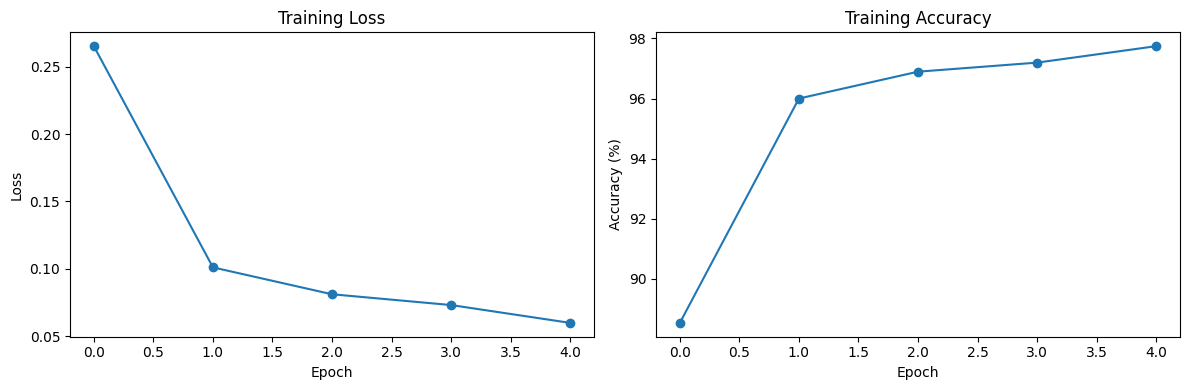

In [15]:
# Plotting functions
def plot_training_progress(losses, accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

plot_training_progress(losses, accuracies)

Visualizes the messages generated by the Sender for different classes.
Each subplot corresponds to a class in CIFAR-10.
Helps in understanding if the messages are class-specific.

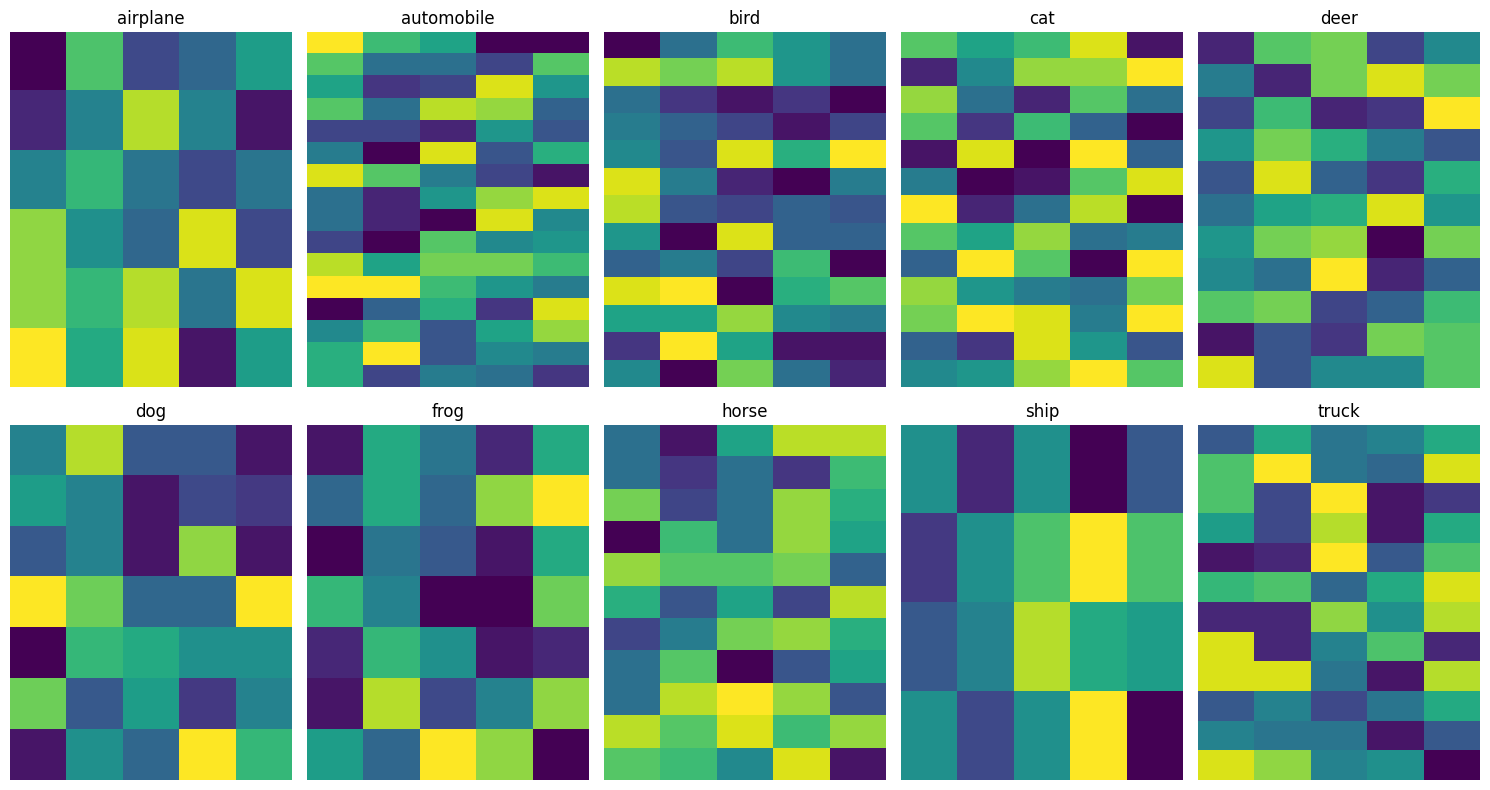

In [18]:
def visualize_messages(sender, dataset, num_samples=10):
    sender.eval()
    class_names = dataset.classes
    messages = []
    labels = []
    
    with torch.no_grad():
        for i in range(num_samples * len(class_names)):
            image, label = dataset[i]
            message_logits = sender(image.unsqueeze(0).to(device))
            message = F.gumbel_softmax(message_logits, tau=temperature, hard=True).argmax(-1)
            messages.append(message.cpu().numpy().flatten())
            labels.append(label)
    
    messages = np.array(messages)
    labels = np.array(labels)
    
    plt.figure(figsize=(15, 8))
    for i, class_name in enumerate(class_names):
        plt.subplot(2, 5, i+1)
        class_messages = messages[labels == i]
        plt.imshow(class_messages, cmap='viridis', aspect='auto')
        plt.title(f'{class_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_messages(sender, train_dataset)

Uses t-SNE to reduce the message dimensionality for visualization.
Colors correspond to different classes.
Checks if messages cluster according to classes.

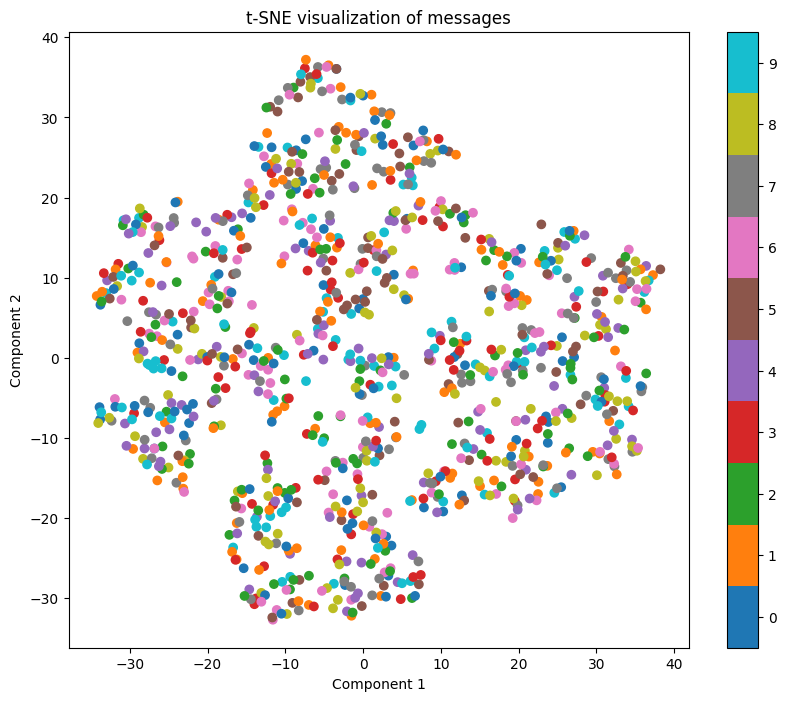

In [16]:
def visualize_message_distribution(sender, dataset, num_samples=1000):
    sender.eval()
    messages = []
    labels = []
    
    with torch.no_grad():
        for i in range(num_samples):
            image, label = dataset[i]
            message_logits = sender(image.unsqueeze(0).to(device))
            message = F.gumbel_softmax(message_logits, tau=temperature, hard=True).argmax(-1)
            messages.append(message.cpu().numpy().flatten())
            labels.append(label)
    
    messages = np.array(messages)
    labels = np.array(labels)
    
    tsne = TSNE(n_components=2, random_state=42)
    messages_2d = tsne.fit_transform(messages)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(messages_2d[:, 0], messages_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter, ticks=range(10))
    plt.clim(-0.5, 9.5)
    plt.title('t-SNE visualization of messages')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

visualize_message_distribution(sender, train_dataset)


Analyzes the Receiver's performance in detail.
Generates a confusion matrix to see how often the Receiver selects the target.
Computes message similarities between the target and candidates.
Visualizes the differences in message similarities for correct and incorrect predictions.

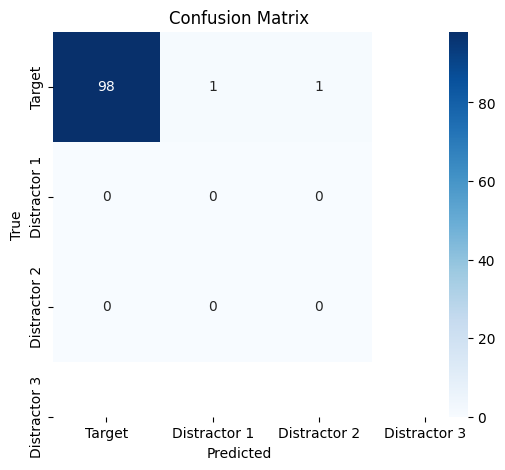

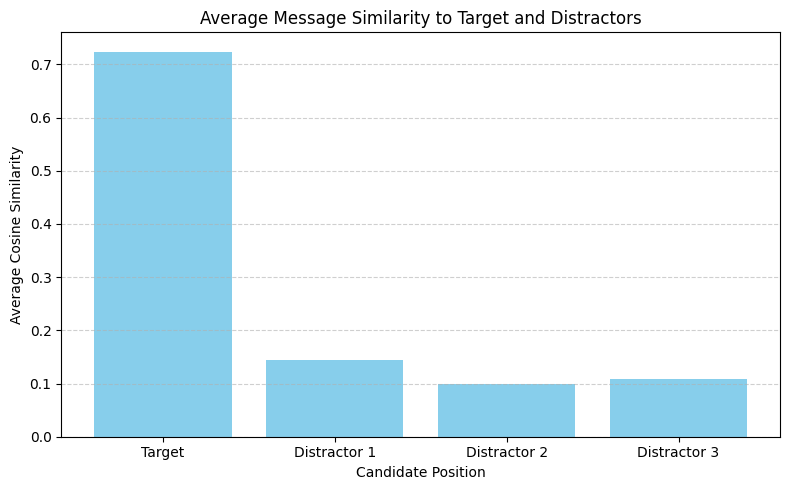

/tmp/ipykernel_46650/484895120.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_similarities[:, 0], incorrect_similarities[:, 0]], labels=['Correct', 'Incorrect'])


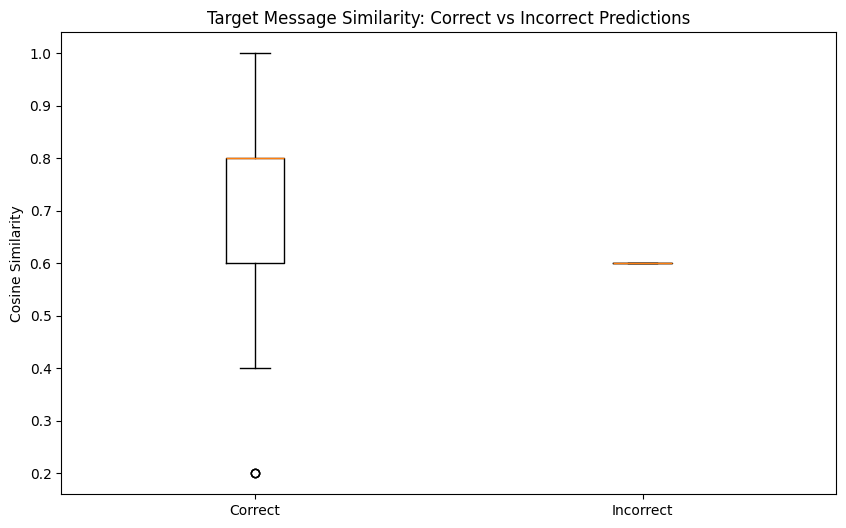


Interpretation:
1. Confusion Matrix: Shows how well the model distinguishes between target and distractors.
   - The higher the diagonal values, the better the model is at correct identification.

2. Message Similarity Analysis:
   - Higher similarity for the target indicates effective communication.
   - Similar values across positions might suggest the model isn't distinguishing well between target and distractors.

3. Correct vs Incorrect Predictions:
   - Higher similarity for correct predictions indicates the model uses message information effectively.
   - Small differences might explain any discrepancies in accuracy.

Overall Accuracy: 98.00%


In [21]:
def analyze_receiver_behavior(sender, receiver, dataset, num_samples=1000, num_distractors=3):
    sender.eval()
    receiver.eval()
    device = next(sender.parameters()).device  # Get the device of the model

    true_labels = []
    predicted_labels = []
    message_similarities = []

    with torch.no_grad():
        for i in range(num_samples):
            # Get target image and label
            target_image, target_label = dataset[i]
            target_image = target_image.unsqueeze(0).to(device)

            # Get distractor images
            distractor_indices = random.sample(range(len(dataset)), num_distractors)
            distractor_images = [dataset[j][0].to(device) for j in distractor_indices]

            # Create candidate images tensor
            candidate_images = torch.stack([target_image.squeeze(0)] + distractor_images).unsqueeze(0)

            # Generate message for target image
            target_message = sender(target_image)

            # Get receiver's prediction
            probs = receiver(target_message, candidate_images)
            predicted_idx = probs.argmax(1).item()

            true_labels.append(0)  # Target is always at index 0
            predicted_labels.append(predicted_idx)

            # Generate messages for candidate images
            other_messages = sender(candidate_images.squeeze(0))
            # Flatten the messages
            target_message_flat = target_message.view(-1)  # Shape: (message_length * vocab_size)
            other_messages_flat = other_messages.view(num_distractors + 1, -1)  # Shape: (num_candidates, message_length * vocab_size)

            # Compute cosine similarity
            similarities = F.cosine_similarity(target_message_flat.unsqueeze(0), other_messages_flat, dim=1)
            message_similarities.append(similarities.cpu().numpy())

    # Define candidate names
    candidate_names = ['Target'] + [f'Distractor {i+1}' for i in range(num_distractors)]

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=candidate_names, yticklabels=candidate_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Message Similarity Analysis
    message_similarities = np.array(message_similarities)  # Shape: (num_samples, num_candidates)
    avg_similarities = message_similarities.mean(axis=0)  # Shape: (num_candidates,)

    # Plot average similarities
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(avg_similarities)), avg_similarities, color='skyblue')
    plt.title('Average Message Similarity to Target and Distractors')
    plt.xlabel('Candidate Position')
    plt.ylabel('Average Cosine Similarity')
    plt.xticks(range(len(avg_similarities)), candidate_names)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Correct vs Incorrect Predictions Analysis
    correct_mask = np.array(true_labels) == np.array(predicted_labels)
    correct_similarities = message_similarities[correct_mask]
    incorrect_similarities = message_similarities[~correct_mask]

    plt.figure(figsize=(10, 6))
    plt.boxplot([correct_similarities[:, 0], incorrect_similarities[:, 0]], labels=['Correct', 'Incorrect'])
    plt.title('Target Message Similarity: Correct vs Incorrect Predictions')
    plt.ylabel('Cosine Similarity')
    plt.show()

    print("\nInterpretation:")
    print("1. Confusion Matrix: Shows how well the model distinguishes between target and distractors.")
    print("   - The higher the diagonal values, the better the model is at correct identification.")
    print("\n2. Message Similarity Analysis:")
    print("   - Higher similarity for the target indicates effective communication.")
    print("   - Similar values across positions might suggest the model isn't distinguishing well between target and distractors.")
    print("\n3. Correct vs Incorrect Predictions:")
    print("   - Higher similarity for correct predictions indicates the model uses message information effectively.")
    print("   - Small differences might explain any discrepancies in accuracy.")

    accuracy = np.mean(correct_mask) * 100
    print(f"\nOverall Accuracy: {accuracy:.2f}%")

analyze_receiver_behavior(sender, receiver, test_dataset, num_samples=100, num_distractors=3)
